In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from triangle_gauss import *
from math import pi
import numpy as np
import scipy
import time
import os
from triangle import triangulate
from scipy.interpolate import griddata
from matplotlib.path import Path
from torch.utils.tensorboard import SummaryWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from utilities import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# ref_p, ref_w = rule(10); ref_p = ref_p.T
# plt.figure(figsize=(6, 6))
# plt.scatter(ref_p[:, 0], ref_p[:, 1], color='blue', marker='o', s=5)
# triangle_vertices = np.array([[0, 0], [1, 0], [0, 1], [0, 0]])  # 闭合三角形
# plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'r-', linewidth=2)
# plt.gca().set_facecolor('#ffffff')

# plt.axis('off')
# plt.show()

In [3]:
# dg = GenMesh2D(boundary_type='regular', param='pq30a0.2e', Nint_elt=15)
# dg.print_grid_info()
# elt_int, elt_weights, edges_int, mesh_edge_w, mesh_normvec, Mesh, ref_Mesh, inv_matrix = dg.get_mesh()
# dg.plot_mesh()
# p = Mesh.reshape(-1, 2)
# p = p.cpu().detach().numpy()
# x = p[:, 0]
# y = p[:, 1]
# plt.figure(figsize=(6, 6))
# plt.scatter(x, y, color='blue', marker='o', s=1)
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.axis('equal')
# plt.show()

In [2]:
class Possion2d_dg:
    def __init__(self, boundary_type: str = 'regular', Nint_elt: int=10, Nint_edge: int = 20, order: int=2, partition: float=0.2) -> None:
        self.name = f'DG_2dPossion_{boundary_type}_{Nint_elt}_{Nint_edge}_{order}_{partition}'
        self.genmesh = GenMesh2D(boundary_type=boundary_type, Nint_edge=Nint_edge, Nint_elt=Nint_elt, param=f'pq30a{partition}e')
        self.torch_type = torch.float64
        #
        self.Nelt = self.genmesh.Nelt
        #
        self.test_func = TestFunction2D()
        self.elt_int, self.elt_weights, self.edges_int, self.mesh_edges_w, self.mesh_normvec, self.Mesh, self.ref_Mesh, self.inv_matrix = self.genmesh.get_mesh()
        self.num_eltinnerp = self.genmesh.num_eltp
        self.num_eltbdp = self.genmesh.num_edgep
        # case 1
        if boundary_type == 'regular':
            self.f = lambda x, y: ((4*x**4-4*x**3+10*x**2-6*x+2)*(y-y**2)*torch.exp(x**2+y**2) + (4*y**4-4*y**3+10*y**2-6*y+2)*(x-x**2)*torch.exp(x**2+y**2))*10
            self.exact = lambda x, y: 10 * x*(1-x)*y*(1-y)*torch.exp(x**2 + y**2)
            self.fxy = self.f(self.elt_int[..., 0], self.elt_int[..., 1])
            self.u_exact = self.exact(self.Mesh[..., 0], self.Mesh[..., 1]).unsqueeze(-1)
        # case 2
        elif boundary_type == 'polygon':
            self.f = lambda x, y: torch.ones_like(x) * 10
            self.fxy = self.f(self.elt_int[..., 0], self.elt_int[..., 1])
            self.get_exact_polygon()
            
            
        #
        self.v_elt_inner, self.v_elt_bd, self.dv_elt_inner = self.get_test(order=order)
        #
        self.model = DGNet(num_modules=self.Nelt, input_size=2, hidden_size=50, output_size=1, num_layers=2, act='tanh').to(device).to(self.torch_type)
        #
        self.Lfbgs = torch.optim.LBFGS(self.model.parameters(), lr=1.0, max_iter=20000, 
                                           max_eval=50000, history_size=50, tolerance_grad=1e-7, 
                                           tolerance_change=1.0 * np.finfo(float).eps, 
                                           line_search_fn='strong_wolfe'); self.lfbgsiter = 0
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-4); self.maxiter = 20000; self.adamiter = 0
    def get_test(self, order: int=2):
        v, dv = self.test_func.Poly(mesh=self.ref_Mesh, order=order)
        
        v_elt_inner, v_elt_bd = v[:, :self.num_eltinnerp], v[:, self.num_eltinnerp:].reshape(-1, 3, self.num_eltbdp)
        dv_elt_inner = dv[:, :self.num_eltinnerp, :]
        dv_elt_inner = torch.matmul(self.inv_matrix[None, :, None, :, :], dv_elt_inner[:, None, :, :].unsqueeze(-1)).squeeze(-1)
        return v_elt_inner, v_elt_bd, dv_elt_inner
    
    def get_exact_polygon(self):
        Mesh = self.Mesh.clone().detach().cpu().numpy()
        exact_dict = np.load('./exact2dpolygon.npz')
        x = exact_dict['x']; y = exact_dict['y']
        u_exact = exact_dict['u_exact']
        comsol_mesh = np.array([x, y]).T
        comsol_u = griddata(comsol_mesh, u_exact, Mesh, method='cubic')
        self.u_exact = torch.from_numpy(comsol_u).unsqueeze(-1).to(device)

    
    def loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # compute local loss
        u_inner, u_bd = u[:, :self.num_eltinnerp, 0], u[:, self.num_eltinnerp:, 0].reshape(self.Nelt, 3, self.num_eltbdp)
        du_inner, du_bd = gradu[:, :self.num_eltinnerp, :], gradu[:, self.num_eltinnerp:, :].reshape(self.Nelt, 3, self.num_eltbdp, 2)
        Int = torch.sum((torch.sum(du_inner[None, ...] * self.dv_elt_inner, dim=-1) - self.fxy[None, ...] * self.v_elt_inner[:, None, :]) * self.elt_weights[None, ...], dim=-1)
        bd = torch.sum(du_bd[None, ...] * self.mesh_normvec[None, :, :, None, :], dim=-1) * self.v_elt_bd[:, None,:, :] * self.mesh_edges_w[None, ...]
        Int = Int - torch.sum(torch.sum(bd, dim=-1), dim=-1) 
        # local_loss = torch.sum(Int**2)
        local_info = torch.sum(Int**2, dim=0)
        local_loss = torch.sum(torch.topk(local_info, k=20, largest=True)[0])
        # compute flux loss
        flux_u = u_bd[self.genmesh.inner_label[:, 0, 0], self.genmesh.inner_label[:, 0, 1], :] - torch.flip(u_bd[self.genmesh.inner_label[:, 1, 0], self.genmesh.inner_label[:, 1, 1], :], dims=[1])

        flux_du = (du_bd[self.genmesh.inner_label[:, 0, 0], self.genmesh.inner_label[:, 0, 1], :, :] - torch.flip(du_bd[self.genmesh.inner_label[:, 1, 0], self.genmesh.inner_label[:, 1, 1], :, :], dims=[1]))**2
        flux_loss = torch.sum(flux_u ** 2) + torch.sum(flux_du)
        # compute boundary loss
        bd_loss = torch.sum(u_bd[self.genmesh.bd_label[:, 0, 0], self.genmesh.bd_label[:, 0, 1], :] ** 2)
        loss = local_loss + flux_loss + bd_loss
        mse = torch.mean((u - self.u_exact)**2)
        mae = torch.max(torch.abs(u - self.u_exact))
        return loss, mse, mae
    
    def exact_loss(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.exact(Mesh[..., 0], Mesh[..., 1]).unsqueeze(-1)
        ux = lambda x, y: ((1-2*x+2*x**2-2*x**3)*y*(1-y)*torch.exp(x**2 + y**2))*10
        uy = lambda x, y: ((1-2*y+2*y**2-2*y**3)*x*(1-x)*torch.exp(x**2 + y**2))*10
        gradu = torch.stack((ux(Mesh[..., 0], Mesh[..., 1]), uy(Mesh[..., 0], Mesh[..., 1])), dim=-1)
        # compute local loss
        u_inner, u_bd = u[:, :self.num_eltinnerp, 0], u[:, self.num_eltinnerp:, 0].reshape(self.Nelt, 3, self.num_eltbdp)
        du_inner, du_bd = gradu[:, :self.num_eltinnerp, :], gradu[:, self.num_eltinnerp:, :].reshape(self.Nelt, 3, self.num_eltbdp, 2)
        Int = torch.sum((torch.sum(du_inner[None, ...] * self.dv_elt_inner, dim=-1) - self.fxy[None, ...] * self.v_elt_inner[:, None, :]) * self.elt_weights[None, ...], dim=-1)
        bd = torch.sum(du_bd[None, ...] * self.mesh_normvec[None, :, :, None, :], dim=-1) * self.v_elt_bd[:, None,:, :] * self.mesh_edges_w[None, ...]
        Int = Int - torch.sum(torch.sum(bd, dim=-1), dim=-1) 
        local_loss = torch.sum(Int**2)
        # compute flux loss
        flux_u = u_bd[self.genmesh.inner_label[:, 0, 0], self.genmesh.inner_label[:, 0, 1], :] - torch.flip(u_bd[self.genmesh.inner_label[:, 1, 0], self.genmesh.inner_label[:, 1, 1], :], dims=[1])

        flux_du = (du_bd[self.genmesh.inner_label[:, 0, 0], self.genmesh.inner_label[:, 0, 1], :, :] - torch.flip(du_bd[self.genmesh.inner_label[:, 1, 0], self.genmesh.inner_label[:, 1, 1], :, :], dims=[1]))**2
        flux_loss = torch.sum(flux_u ** 2) + torch.sum(flux_du)
        # compute boundary loss
        bd_loss = torch.sum(u_bd[self.genmesh.bd_label[:, 0, 0], self.genmesh.bd_label[:, 0, 1], :] ** 2)
        loss = local_loss + flux_loss + bd_loss
        return loss
    
    def loss_lfbgs(self):
        self.Lfbgs.zero_grad()
        loss, mse, mae = self.loss()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter + self.adamiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        loss.backward()
        self.lfbgsiter += 1
        if self.lfbgsiter % 100 == 0:
            print(f"LBFGS At iter: {self.lfbgsiter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
        return loss
    
    def loss_adam(self):
        self.Adam.zero_grad()
        loss, mse, mae = self.loss()
        self.writer.add_scalar(f"mse_vs_iter", mse, self.lfbgsiter + self.adamiter)
        self.writer.add_scalar(f"mse_vs_time", mse, time.time() - self.t)
        self.adamiter += 1
        if self.adamiter % 100 == 0:
            print(f"Adam At iter: {self.adamiter}, loss_train:{loss.item():.6f}, mse:{mse.item():.6f}, mae:{mae.item():.6f}")
        return loss
    def train(self):
        print('*********** Started training ...... ***************')
        self.writer = SummaryWriter(f'./logs/possion2d/DGNet')
        self.t = time.time()
        self.Lfbgs.step(self.loss_lfbgs)
        loss = self.loss_adam()
        best_loss = loss
        while loss > 1e-5:
            loss.backward()
            self.Adam.step()
            loss = self.loss_adam()
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/DGNet/{self.name}.pth')
            if self.adamiter > self.maxiter:
                break
        self.adamiter = 0
        print(f'Finished training in {time.time()-self.t:.4f} seconds')
    def load(self):
        path = f'./models/DGNet/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False

class Possion2d_base:
    def __init__(self, boundary_type: str = 'regular', N_points: int=100, Nint_edge: int = 20,\
                 method: str = 'PINN', num_layers: int = 3, hidden_size: int = 50, act: str = 'tanh') -> None:
        self.name = f'2dPossion_{boundary_type}_{N_points}_{Nint_edge}_{num_layers}_{hidden_size}_{act}'
        self.genmesh = GenMesh2D(boundary_type=boundary_type, Nint_edge=20, Nint_elt=15, param=f'pq30a0.05e')
        #
        self.Nelt = self.genmesh.Nelt
        self.method = method
        self.boundary_type = boundary_type
        self.Nint_edge = Nint_edge
        #
        self.inner_p, self.edges_p = self.get_mesh(N_points, Nint_edge)
        self.Mesh = torch.cat((self.inner_p, self.edges_p), dim=0)
        self.N = self.inner_p.shape[0]
        if method == 'PINN':
            _, _, _, _, _, self.Mesh_test, _, _ = self.genmesh.get_mesh()
            self.model = MLP(input_size=2, hidden_size=hidden_size, output_size=1, num_layers=num_layers, act=act).to(device).to(torch.float64)
        elif method == 'DeepRitz':
            self.Mesh_test, _, _, _, _, _, _, _ = self.genmesh.get_mesh()
            self.model = ResNet(input_size=2, hidden_size=hidden_size, output_size=1, num_layers=num_layers, act=act).to(device).to(torch.float64)
        
        # case 1
        if boundary_type == 'regular':
            self.f = lambda x, y: ((4*x**4-4*x**3+10*x**2-6*x+2)*(y-y**2)*torch.exp(x**2+y**2) + (4*y**4-4*y**3+10*y**2-6*y+2)*(x-x**2)*torch.exp(x**2+y**2))*10
            self.exact = lambda x, y: 10 * x*(1-x)*y*(1-y)*torch.exp(x**2 + y**2)
            self.fxy = self.f(self.Mesh[..., 0], self.Mesh[..., 1])
            self.u_exact = self.exact(self.Mesh[..., 0], self.Mesh[..., 1]).unsqueeze(-1)
        # case 2
        elif boundary_type == 'polygon':
            self.f = lambda x, y: torch.ones_like(x) * 10
            self.fxy = self.f(self.Mesh[..., 0], self.Mesh[..., 1])
            self.get_exact_polygon()
        #
        self.Adam = torch.optim.Adam(self.model.parameters(), lr=1e-3); self.maxiter = 20000; self.adamiter = 0

    def get_exact_polygon(self):
        Mesh = self.Mesh_test.clone().detach().cpu().numpy()
        exact_dict = np.load('./exact2dpolygon.npz')
        x = exact_dict['x']; y = exact_dict['y']
        u_exact = exact_dict['u_exact']
        comsol_mesh = np.array([x, y]).T
        comsol_u = griddata(comsol_mesh, u_exact, Mesh, method='cubic')
        self.u_exact = torch.from_numpy(comsol_u).unsqueeze(-1).to(device)
    
    def get_mesh(self, N_points: int, Nint_edge: int):
        v = np.array(self.genmesh.vertices)
        e = np.array(self.genmesh.segments)
        t = np.linspace(0, 1, Nint_edge)
        x = (v[e[:, 0]] - v[e[:, 1]])[:, None, :] * t[None, :, None] + v[e[:, 1]][:, None, :]
        edges_p = torch.tensor(x.reshape(-1, 2)).to(device)
        if self.boundary_type == 'regular':
            x = np.linspace(0, 1, N_points)
            y = np.linspace(0, 1, N_points)
            X, Y = np.meshgrid(x, y)
            Mesh = np.vstack([X.ravel(), Y.ravel()]).T
        elif self.boundary_type == 'polygon':   
            vtx = np.array(self.genmesh.vertices)
            path = Path(vtx)
            x = np.linspace(-1, 1, N_points)
            y = np.linspace(-0.9, 1.1, N_points)
            X, Y = np.meshgrid(x, y)
            mesh_all = np.vstack([X.ravel(), Y.ravel()]).T
            mask = path.contains_points(mesh_all)
            Mesh = mesh_all[mask]
        Mesh = torch.tensor(Mesh).to(device)
        return Mesh, edges_p
    
    def pinn(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        uxx = torch.autograd.grad(gradu[..., 0], Mesh, grad_outputs=torch.ones_like(gradu[..., 0]), create_graph=True)[0][..., 0]
        uyy = torch.autograd.grad(gradu[..., 1], Mesh, grad_outputs=torch.ones_like(gradu[..., 1]), create_graph=True)[0][..., 1]
        eq_loss = torch.sum((uxx + uyy + self.f(Mesh[..., 0], Mesh[..., 1]))**2)
        u_edge = u[self.N:, :]
        bd_loss = torch.sum(u_edge**2)
        loss = eq_loss + 100 * bd_loss
        u_test = self.model(self.Mesh_test)
        mse = torch.mean((u_test - self.u_exact)**2)
        mae = torch.max(torch.abs(u_test - self.u_exact))
        return loss, mse, mae
    
    def deepritz(self):
        Mesh = self.Mesh.clone().detach().requires_grad_(True).to(device)
        u = self.model(Mesh)
        gradu = torch.autograd.grad(u, Mesh, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        eq_loss = torch.sum(0.5 * (gradu[..., 0]**2 + gradu[..., 1]**2) - self.f(Mesh[..., 0], Mesh[..., 1])*u.squeeze(-1))
        u_edge = u[self.N:, :]
        bd_loss = torch.sum(u_edge**2)
        loss = eq_loss + 500 * bd_loss
        u_test = self.model(self.Mesh_test)
        mse = torch.mean((u_test - self.u_exact)**2)
        mae = torch.max(torch.abs(u_test - self.u_exact))
        return loss, mse, mae
    
    
    def loss(self):
        if self.method == 'PINN':
            return self.pinn()
        elif self.method == 'DeepRitz':
            return self.deepritz()
        else:
            raise ValueError(f"Invalid method: {self.method}")

    def train(self):
        print('*********** Started training ...... ***************')
        t = time.time()
        self.writer = SummaryWriter(f'./logs/possion2d/{self.method}')
        loss, mse, mae = self.loss()
        best_loss = loss
        epoch = 0
        # while  mse.item() > 1e-3:
        while  epoch < self.maxiter:
            self.Adam.zero_grad()
            loss, mse, mae = self.loss()
            self.writer.add_scalar(f"mse_vs_iter", mse, epoch)
            self.writer.add_scalar(f"mse_vs_time", mse, time.time() - t)
            loss.backward()
            self.Adam.step()
            epoch += 1
            if loss < best_loss:
                best_loss = loss
                torch.save(self.model.state_dict(), f'./models/{self.method}/{self.name}.pth')
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.6f}, mse = {mse.item():.6f}, mae = {mae.item():.6f}")
            # if epoch > self.maxiter:
            #     break
            # if mae.item() < 1e-4:
            #     print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Exact Loss = {mse.item():.6f}")
            #     break
        self.writer.close()
        print(f'Finished training in {time.time()-t:.4f} seconds')
    def load(self):
        path = f'./models/{self.method}/{self.name}.pth'
        if os.path.exists(path):
            print("Loading saved model...")
            model_dict = torch.load(path)
            self.model.load_state_dict(model_dict)
            return True
        else:
            print("No saved model found. Need to train")
            return False


In the whole domain: 
118 points
175 elements
291 faces/edges
Plot the mesh:


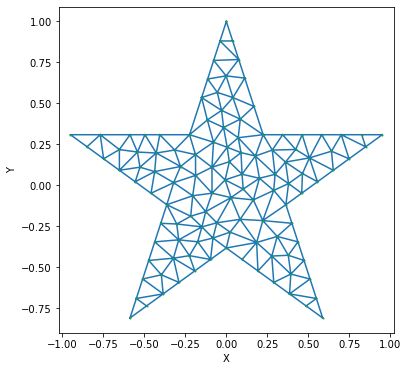

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_12294/1335389546.py", line 4, in <cell line: 4>
    P_dgnet.exact_loss()
  File "/tmp/ipykernel_12294/2034292436.py", line 81, in exact_loss
    u = self.exact(Mesh[..., 0], Mesh[..., 1]).unsqueeze(-1)
AttributeError: 'Possion2d_dg' object has no attribute 'exact'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1

In [ ]:
P_dgnet = Possion2d_dg(boundary_type='polygon', Nint_elt=15, Nint_edge=20, order=3, partition=0.01)
P_dgnet.genmesh.print_grid_info()
P_dgnet.genmesh.plot_mesh()
# P_dgnet.exact_loss()


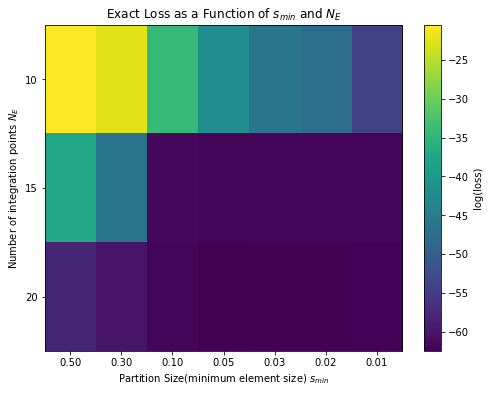

In [32]:
N_int_elt = [10, 15, 20]
N_partitions = [0.5, 0.3, 0.1, 0.05, 0.03, 0.02, 0.01]
N_deg = [3, 6, 10, 20, 30, 60]

# 初始化存储 exact loss 的数组，行对应 N_int, 列对应 N_x
losses = np.zeros((len(N_int_elt), len(N_partitions)))

# 遍历参数组合，计算 exact loss
for i, N_int in enumerate(N_int_elt):
    for j, N_partition in enumerate(N_partitions):
        P = Possion2d_dg(boundary_type='regular', Nint_elt=N_int, Nint_edge=20, order=3, partition=N_partition)
        losses[i, j] = P.exact_loss()


# losses = np.zeros((len(N_deg), len(N_partitions)))

# # 遍历参数组合，计算 exact loss
# for i, deg in enumerate(N_deg):
#     for j, N_partition in enumerate(N_partitions):
#         P = Possion2d_dg(boundary_type='regular', Nint_elt=15, Nint_edge=20, order=deg, partition=N_partition)
#         losses[i, j] = P.exact_loss()
plt.figure(figsize=(8, 6))
im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')

plt.colorbar(im, label='log(loss)')

plt.xticks(range(len(N_partitions)), labels=[f"{p:.2f}" for p in N_partitions])
plt.yticks(range(len(N_int_elt)), labels=[f"{n}" for n in N_int_elt])

plt.xlabel(r'Partition Size(minimum element size) $s_{min}$')
plt.ylabel(r'Number of integration points $N_{E}$')
plt.title('Exact Loss as a Function of $s_{min}$ and $N_{E}$')
# 显示图像
plt.show()

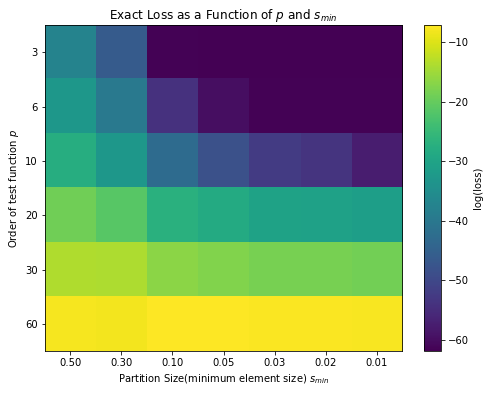

In [30]:
plt.figure(figsize=(8, 6))
im = plt.imshow(np.log(losses), cmap='viridis', origin='upper', aspect='auto')

plt.colorbar(im, label='log(loss)')

plt.xticks(range(len(N_partitions)), labels=[f"{p:.2f}" for p in N_partitions])
plt.yticks(range(len(N_deg)), labels=[f"{n}" for n in N_deg])

plt.xlabel(r'Partition Size(minimum element size) $s_{min}$')
plt.ylabel(r'Order of test function $p$')
plt.title('Exact Loss as a Function of $p$ and $s_{min}$')
# 显示图像
plt.show()

## begin training

DG_2dPossion_polygon_15_20_3_0.06
In the whole domain: 
35 points
38 elements
71 faces/edges
Plot the mesh:


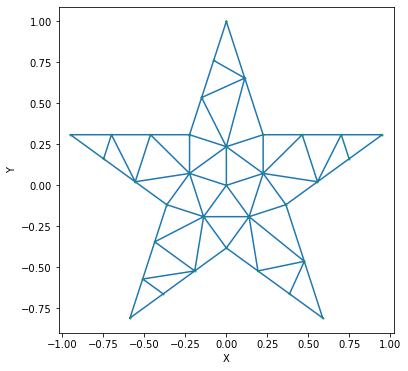

Loading saved model...
train loss:  tensor(0.0149, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0.0002, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>) tensor(0.0286, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


/root/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


: 

In [6]:
P_dgnet = Possion2d_dg(boundary_type='polygon', Nint_elt=15, Nint_edge=20, order=3, partition=0.05)
print(P_dgnet.name)
P_dgnet.genmesh.print_grid_info()
P_dgnet.genmesh.plot_mesh()
# p.load()
retrain = False
if P_dgnet.load() and not retrain:
    print("train loss: ", P_dgnet.loss()[0], P_dgnet.loss()[1], P_dgnet.loss()[2])
elif retrain:
    P_dgnet.load()
    # while p.loss()[2] > 1e-4:
    P_dgnet.train()

In [7]:
P_deepritz = Possion2d_base(boundary_type='polygon', N_points = 100, method='DeepRitz', Nint_edge=1000, num_layers=4, hidden_size=128, act='tanh')
# P_deepritz.load()
P_deepritz.train()

*********** Started training ...... ***************
Epoch 100: Loss = -784.890081, mse = 0.058677, mae = 0.519181
Epoch 200: Loss = -854.280796, mse = 0.058588, mae = 0.519309
Epoch 300: Loss = -871.994900, mse = 0.058968, mae = 0.520687
Epoch 400: Loss = -879.149882, mse = 0.059184, mae = 0.521473
Epoch 500: Loss = -881.912691, mse = 0.059294, mae = 0.521873
Epoch 600: Loss = -883.170214, mse = 0.059341, mae = 0.522046
Epoch 700: Loss = -883.973271, mse = 0.059354, mae = 0.522092
Epoch 800: Loss = -884.626443, mse = 0.059352, mae = 0.522081
Epoch 900: Loss = -885.206831, mse = 0.059345, mae = 0.522045
Epoch 1000: Loss = -885.737061, mse = 0.059334, mae = 0.522001
Epoch 1100: Loss = -886.228868, mse = 0.059324, mae = 0.521954
Epoch 1200: Loss = -886.691549, mse = 0.059312, mae = 0.521905
Epoch 1300: Loss = -887.133143, mse = 0.059301, mae = 0.521855
Epoch 1400: Loss = -887.560555, mse = 0.059289, mae = 0.521804
Epoch 1500: Loss = -887.979690, mse = 0.059277, mae = 0.521751
Unexpected e

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_29700/541988888.py", line 3, in <cell line: 3>
    P_deepritz.train()
  File "/tmp/ipykernel_29700/2034292436.py", line 271, in train
    if loss < best_loss:
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/root/anaconda3/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structured_traceback(
  File "/root/an

In [8]:
P_pinn = Possion2d_base(boundary_type='polygon', method='PINN', Nint_edge=100, num_layers=3, hidden_size=128, act='tanh')
P_pinn.load()
# P_pinn.train()

Loading saved model...


True

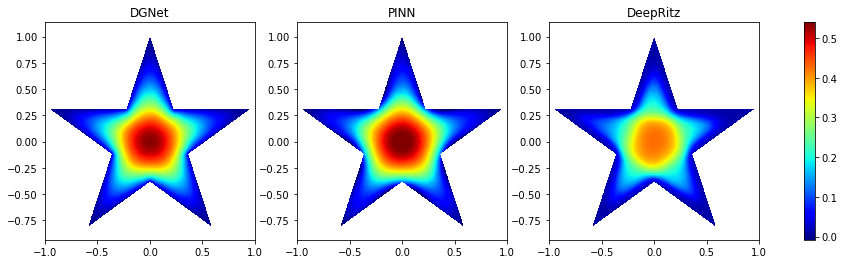

In [11]:
vtx = np.array(P_dgnet.genmesh.vertices)
path = Path(vtx)
xmin, ymin = vtx.min(axis=0)
xmax, ymax = vtx.max(axis=0)
x = np.linspace(-1, 1, 2000)
y = np.linspace(-0.9, 1.1, 2000)
X, Y = np.meshgrid(x, y)
mask = path.contains_points(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
m = np.where(mask, np.nan, 0)
cmap2 = plt.get_cmap('jet').copy()
cmap2.set_bad(alpha=0) 
cmap2.set_under('white') 

Mesh = P_dgnet.Mesh
u_deepritz = P_deepritz.model(Mesh)
u_dgnet = P_dgnet.model(Mesh)
u_pinn = P_pinn.model(Mesh)
# print(P_deepritz.loss())
u_exact = P_dgnet.u_exact
Mesh = Mesh.detach().cpu().numpy().reshape(-1, 2)
u_deepritz_pred = u_deepritz.detach().cpu().numpy().flatten()
u_dgnet_pred = u_dgnet.detach().cpu().numpy().flatten()
u_pinn_pred = u_pinn.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
error1 = abs(u_dgnet_pred - u_exact)
error2 = abs(u_pinn_pred - u_exact)
error3 = abs(u_deepritz_pred - u_exact)




# 计算误差的范围（共享 colorbar）
# vmin = min(error1.min(), error2.min(), error3.min())
# vmax = max(error1.max(), error2.max(), error3.max())
#
# vmin = min(u_dgnet_pred.min(), u_pinn_pred.min(), u_deepritz_pred.min())
# vmax = max(u_dgnet_pred.max(), u_pinn_pred.max(), u_deepritz_pred.max())
#
vmin = u_exact.min()
vmax = u_exact.max()
#
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("jet")

# a = axes[0].tricontourf(Mesh[:, 0], Mesh[:, 1], error1, levels=100, cmap=cmap, norm=norm)
# axes[0].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
# b = axes[1].tricontourf(Mesh[:, 0], Mesh[:, 1], error2, levels=100, cmap=cmap, norm=norm)
# axes[1].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
# c = axes[2].tricontourf(Mesh[:, 0], Mesh[:, 1], error3, levels=100, cmap=cmap, norm=norm)
# axes[2].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
#
a = axes[0].tricontourf(Mesh[:, 0], Mesh[:, 1], u_dgnet_pred, levels=100, cmap=cmap, norm=norm)
axes[0].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
b = axes[1].tricontourf(Mesh[:, 0], Mesh[:, 1], u_pinn_pred, levels=100, cmap=cmap, norm=norm)
axes[1].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
c = axes[2].tricontourf(Mesh[:, 0], Mesh[:, 1], u_deepritz_pred, levels=100, cmap=cmap, norm=norm)
axes[2].pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, orientation='vertical')
# cbar.set_label()
# axes[0].set_xlabel('x')
# axes[0].set_ylabel('y')
# axes[1].set_xlabel('x')
# axes[1].set_ylabel('y')
# axes[2].set_xlabel('x')
# axes[2].set_ylabel('y')
axes[0].axis('equal')
axes[1].axis('equal')
axes[2].axis('equal')

# 设置标题
axes[0].set_title("DGNet")
axes[1].set_title("PINN")
axes[2].set_title("DeepRitz")
# fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
plt.show()


In [6]:
from matplotlib.path import Path
# 第二层
vtx = np.array(P_dgnet.genmesh.vertices)
path = Path(vtx)
xmin, ymin = vtx.min(axis=0)
xmax, ymax = vtx.max(axis=0)
x = np.linspace(-1, 1, 2000)
y = np.linspace(-0.9, 1.1, 2000)
X, Y = np.meshgrid(x, y)
mask = path.contains_points(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
m = np.where(mask, np.nan, 0)
cmap2 = plt.get_cmap('jet').copy()
cmap2.set_bad(alpha=0) 
cmap2.set_under('white') 

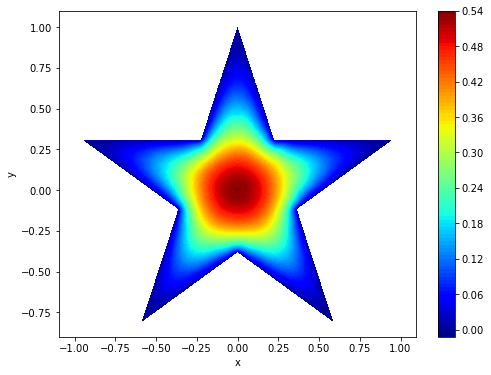

In [7]:
# 第一层
Mesh = P_dgnet.Mesh
u = P_dgnet.model(Mesh)
u_exact = P_dgnet.u_exact
Mesh = Mesh.detach().cpu().numpy().reshape(-1, 2)
udg_pred = u.detach().cpu().numpy().flatten()
u_exact = u_exact.detach().cpu().numpy().flatten()


plt.figure(figsize=(8, 6))
# plt.tricontourf(Mesh[:, 0], Mesh[:, 1], abs(udg_pred-u_exact), levels=100, cmap='jet')
plt.tricontourf(Mesh[:, 0], Mesh[:, 1], udg_pred, levels=100, cmap='jet')
plt.colorbar()
plt.pcolormesh(X, Y, m, cmap=cmap2, vmin=0.2, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()